# Actividad 3 - Segmentación de Imagenes

---
Asignatura: **Percepción Computacional**

Equipo: **1021H**

Integrantes: **Christian López Varela, Edgar Arteaga Valencia, Ayrton Emmanuel Teniente Muñiz**

---

## Objetivo

El objetivo de este trabajo es aprender a construir y evaluar el rendimiento de uno o más segmentadores. Esta actividad permitirá consolidar los conceptos sobre segmentación de imágenes aprendidos.

En todos los modelos se usará segmentación semántica a excepción de YOLOv8 que usa segmentación de instancia. Se intentará segmentar los automóviles de las siguientes imágenes, teniendo como principales caracteristicas el ruido en la primera imagen, una imagen limpia en la segunda y varios objetos en la tercera. Una característica principal de las imagenes es que todas son imagenes con vista aérea.

<div style='display: flex'>
<img style="width: 33%; display: block; margin: auto;" src="./images/car1.png"/>
<img style="width: 33%; display: block; margin: auto;" src="./images/car2.png"/>
<img style="width: 33%; display: block; margin: auto;" src="./images/car3.png"/>
</div>

# Segmentación semántica


La segmentación semántica es una técnica que consiste en clasificar cada pixel de una imágen en una categoría o clase predefinida. Por ejemplo, en una imágen con personas y autos, la segmentación semántica etiquetará los pixeles que pertenecen unicamente a personas, y usará otra etiqueta para los pixeles que pertenecen a la clase carros.

La segmentación semántica es útil para diferenciar distintas clases de objetos pero no separa las instancias. Siguiendo el ejemplo anterior, se pueden distinguir las personas pero no se hace la separación de cada persona. El proceso de segmentación semántica se logra generalmente con `modelos de aprendizaje profundo`, especialmente con redes neurales convolucionales `CNNs`.

El modelo utiliza la `convolución atrous`. Este tipo de convolución agrega el parámetro `dilatation rate (r)`, que introduce espacios entre los puntos del kernel. El objetivo es obtener un mejor contexto de la imágen en cada evaluación de los pixeles del kernel sin sacrificar procesamiento. Un kernel en la convolución atrous con `rate=1` de `3x3` es igual a un kernel convencional `3x3`. La siguiente imágen muestra como se vería el kernel con `rate=2` y `rate=3`, en ella se pueden apreciar los espacios que se agregan.

<img style="width: 30%; display: block; margin: auto;" src="./images/atrous-deeplab.png"/>

El resultado de la segmentación semántica es una máscara de segmentación donde cada clase de objeto tiene un color asociado.

# Ground truth para validar modelos de segmentación

`Ground truth` hace referencia a los datos que se usan para validar y probar un modelo de inteligencia artifical. Esto datos representan lo que se espera en la predicción del modelo, por lo tanto, se pueden usar para comparar la salida del modelo con la respuesta correcta/esperada.

El ground truth en modelos de segmentación se valida con la métrica de `intersection over union`. Los valores estan en el rango de `0 a 1`, donde 1 representa una respuesta totalmente acertada. En la validación de segmentación esto sería el equivalente a obtener una máscara idéntica a la máscara del ground truth. La fórmula se suele representar con una nomenclatura de conjuntos.

<img style="width: 30%; display: block; margin: auto;" src="./images/iou.png"/>

Los valores de entrada para calcular `intersection over union` son:
- Imagenes del mismo tamaño
- Binarizar para facilitar el proceso cuando las máscaras son blanco y negro
- En el caso de usar RGB, los colores para ambas máscaras deben coincidir

Debido a que se usarán imagenes que no son parte de los modelos de entrenamiento, se tiene que crear la máscara de ground truth de forma manual. Para ello se pueden utilizar programas como Photoshop o Label Studio. En ellos se cargan las imagenes, se marcan los labels de los objetos que se desean predecir con el modelo y se exportan a un formato que sea adecuado para trabajar con el cálculo de intersection over union.

Ejemplo de label manual con [`Label Studio`](https://github.com/HumanSignal/label-studio?tab=readme-ov-file#try-out-label-studio):

<img style="width: 50%; display: block; margin: auto;" src="./images/label_studio.png"/>

# Segmentación semántica de autos con DeepLabv3 Resnet101

`deeplabv3_resnet101` es un modelo pre-entrenado de PyTorch. El modelo esta entrenado con un subconjunto del dataset `COCO` y hace uso de 20 de las categorías que se encuentran presente en el dataset de `Pascal VOC`. Para este ejercicio se utilizará la `categoría 7` que representa los automóviles, de esta forma probaremos el modelo con distintas imágenes de autos vistos desde arriba.

Cabe mencionar que los automóviles que se usaron en el entrenamiento del dataset `COCO` son mayormente de autos vistos de manera ya sea frontal, lado o posterior. Esto se puede comprobar en la página de exploración del dataset <a href='https://cocodataset.org/#explore' target='_blank'>https://cocodataset.org/#explore</a>. Aún asi se probará el modelo usando las imagenes de autos vistos de arriba de distintas maneras para verificar los resultados.

### Código

- get_img_with_arr
  - Carga la imágen especificada y su array
- load_model
  - Carga el modelo de DeepLabV3 resnet101
- semantic_segmentation
  - Genera la máscara de la segmentación semántica sobre la imágen que se pasa como parámetro
- show_images
  - Muestra la imágen original, imágen de ground truth e imágen de la máscara de segmentación semántica
- calculate_iou
  - Cálculo `Intersection Over Union` para evaluar la máscara generada en la segmentación

El código de las funciones `load_model` y `semantic_segmentation` fue tomado en su mayoria de la página oficial de PyTorch: <a href='https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/' target='_blank'>https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/</a>

Se hicieron unas modificaciones especialmente en la parte en como el modelo selecciona las probabilidades de los pixeles para cada categoría. El ejemplo en PyTorch utiliza `argmax`, para obtener la predicción máxima de cada clase. El resultado fue una mala predicción para los automóviles y objetos en general, esto se puede apreciar en la siguiente imágen.

<img style="width: 30%; display: block; margin: auto;" src="./images/armax_car.png"/>

Para corregir el problema de `argmax`, se aplicó `sigmoid` para convertir la predicción a probabilidades (valores de 0 a 1) y se añadió un parámetro de `probabilidad mínima`. Esto permite seleccionar la clase de un pixel siempre que la probabilidad sea como mínimo el valor que se asigne a `min_prob` (default 0.9). Adicionalmente se agregó al código el cálculo de la probabilidad unicamente para automóviles (`car_index = 7`).

In [2]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

def get_img_with_arr(img_path, as_binary=False):
    img_original = Image.open(img_path).convert('RGB')# Convert to RGB to avoid 4 channel problems
    img_original_arr = np.array(img_original)
    if(as_binary):
        img_original_arr = img_original.convert('1')
    return (img_original, img_original_arr)

def load_model():
    model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
    model.eval()
    return model

def semantic_segmentation(model, img_path, min_prob = 0.90):
    # Load image
    img_original, _ = get_img_with_arr(img_path)

    # Configure the model
    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    input_batch = preprocess(img_original).unsqueeze(0)

    # Use cuda if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out']

    # Convert to probabilities (value between 0 and 1), cars only
    car_index = 7
    car_prob = output[0][car_index].sigmoid()

    # Select pixels where probability of being a car is > min_prob
    mask_binary = (car_prob > min_prob).cpu().numpy().astype(np.uint8)

    return (img_original, mask_binary)

def show_images(img_original, img_gt, img_pred):
    # Display images side by side
    plt.figure(figsize=(20, 5), num='Semantic Segmentation')

    for index, img in enumerate([img_original, img_gt, img_pred]):
        plt.subplot(1, 3, index+1)
        plt.title(img['title'])
        plt.imshow(img['img_data'], cmap=plt.cm.gray)
        plt.axis('off')

    plt.show()

def calculate_iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union    

model = load_model()


## Resultados de segmentación semántica con DeepLabV3 Resnet101

Intersection over Union -> car1: 0.40552312612413766
Intersection over Union -> car2: 0.8858075943761763
Intersection over Union -> car3: 0.2905132270863938


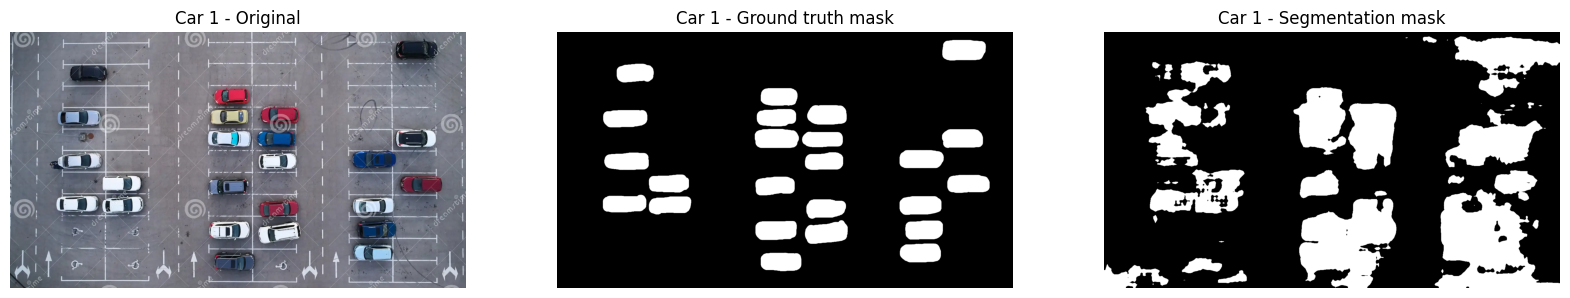

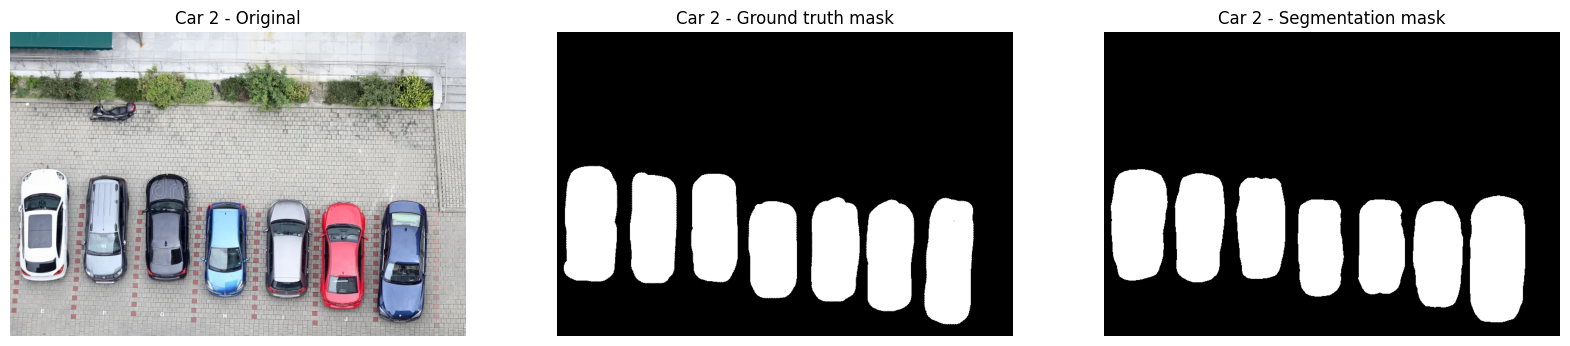

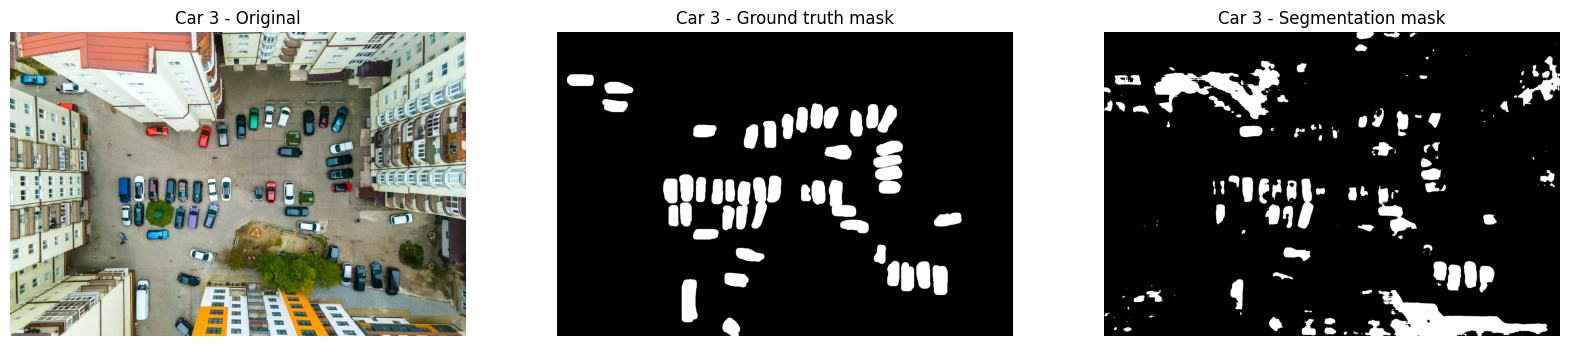

In [3]:
# Get segmentation mask images
car1, pred_mask_car_arr1 = semantic_segmentation(model, './images/car1.png')
car2, pred_mask_car_arr2 = semantic_segmentation(model, './images/car2.png')
car3, pred_mask_car_arr3 = semantic_segmentation(model, './images/car3.png')

# Load ground truth images
_, gt_mask_car_arr1 = get_img_with_arr('./images/car1_ground_truth.png', as_binary=True)
_, gt_mask_car_arr2 = get_img_with_arr('./images/car2_ground_truth.png', as_binary=True)
_, gt_mask_car_arr3 = get_img_with_arr('./images/car3_ground_truth.png', as_binary=True)

# Ground Truth - Calculate Intersection over Union
print('Intersection over Union -> car1: ' + str(calculate_iou(pred_mask_car_arr1, gt_mask_car_arr1)))
print('Intersection over Union -> car2: ' + str(calculate_iou(pred_mask_car_arr2, gt_mask_car_arr2)))
print('Intersection over Union -> car3: ' + str(calculate_iou(pred_mask_car_arr3, gt_mask_car_arr3)))

# Display original images and masks
show_images({ 'title': 'Car 1 - Original', 'img_data': car1 }, { 'title': 'Car 1 - Ground truth mask', 'img_data': gt_mask_car_arr1 }, { 'title': 'Car 1 - Segmentation mask', 'img_data': pred_mask_car_arr1})
show_images({ 'title': 'Car 2 - Original', 'img_data': car2 }, { 'title': 'Car 2 - Ground truth mask', 'img_data': gt_mask_car_arr2 }, { 'title': 'Car 2 - Segmentation mask', 'img_data': pred_mask_car_arr2})
show_images({ 'title': 'Car 3 - Original', 'img_data': car3 }, { 'title': 'Car 3 - Ground truth mask', 'img_data': gt_mask_car_arr3 }, { 'title': 'Car 3 - Segmentation mask', 'img_data': pred_mask_car_arr3})

Los resultados anteriores muestran un buen desempeño en la imágen `car2`. Esto posiblemente a que la imágen no contiene ruido y no existen muchos objetos que interfieren con la predicción del modelo.

El modelo muestra un peor desempeño en `car1` y `car3`. A simple vista se puede notar que las máscaras de segmentación tienen más pixeles en areas donde no estan los carros. Este problema se puede intentar mejorar aumentando la probabilidad mínima para descartar pixeles que no pertenecen a la clase carro. Dependiendo de como fue entrenado el modelo, se pueden obtener mejores resultados cambiándo la orientación de la imágen. El siguiente código muestra como el modelo tiene mejores predicciones para `car1` aplicando lo antes mencionado.

Intersection over Union -> car1         : 0.42698912916611326
Intersection over Union -> car1 vertical: 0.6170763260025873


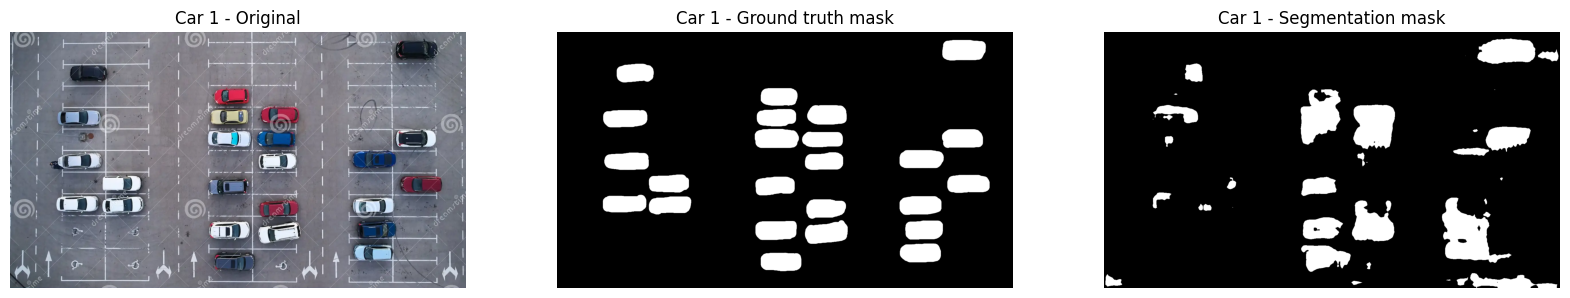

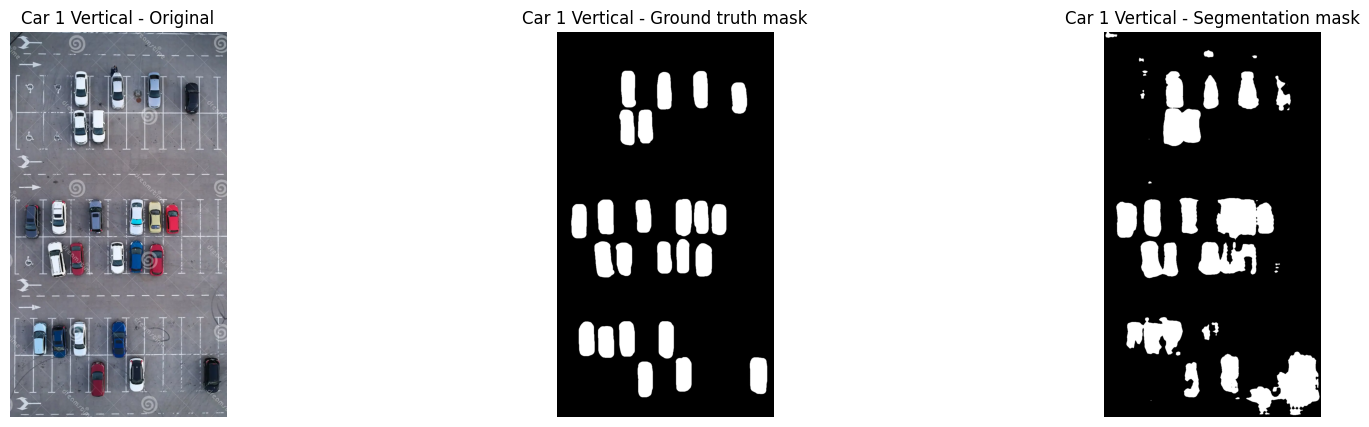

In [4]:
# Get segmentation mask image
car1, pred_mask_car_arr1 = semantic_segmentation(model, './images/car1.png', min_prob=0.95)
car1_vertical, pred_mask_car_vertical_arr1 = semantic_segmentation(model, './images/car1_vertical.png', min_prob=0.95)

# Load ground truth image
_, gt_mask_car_vertical_arr1 = get_img_with_arr('./images/car1_vertical_ground_truth.png', as_binary=True)

# Ground Truth - Calculate Intersection over Union
print('Intersection over Union -> car1         : ' + str(calculate_iou(pred_mask_car_arr1, gt_mask_car_arr1)))
print('Intersection over Union -> car1 vertical: ' + str(calculate_iou(pred_mask_car_vertical_arr1, gt_mask_car_vertical_arr1)))

# Display original image and masks
show_images({ 'title': 'Car 1 - Original', 'img_data': car1 }, { 'title': 'Car 1 - Ground truth mask', 'img_data': gt_mask_car_arr1 }, { 'title': 'Car 1 - Segmentation mask', 'img_data': pred_mask_car_arr1})
show_images({ 'title': 'Car 1 Vertical - Original', 'img_data': car1_vertical }, { 'title': 'Car 1 Vertical - Ground truth mask', 'img_data': gt_mask_car_vertical_arr1 }, { 'title': 'Car 1 Vertical - Segmentation mask', 'img_data': pred_mask_car_vertical_arr1})

En el caso de `car3`, se aplicó los mismos pasos que en `car1`. El modelo no obtuvo mejores predicciones para la clase carro. Esto puede ser debido a que la imágen contiene más elementos que interfieren con el etiquetado de pixeles. Otra razón puede ser que la resolución de la imágen es demasiado grande. Asi pues, se agregó un escenario más para validar el modelo. Para ello se usaron imagenes donde se recortó la imágen original de `car3` de manera que contenga carros y otros elementos que puedan interferir con la predicción y se aplicó la validación tanto en la orientación horizontal como vertical. El resultado muestra una mejora pero únicamente en la imágen recortada con orientación vertical.

Intersection over Union -> car3             : 0.2905132270863938
Intersection over Union -> car3 vertical    : 0.34255885028883126
Intersection over Union -> car3 cut         : 0.2670574103759522
Intersection over Union -> car3 cut vertical: 0.690153057947414


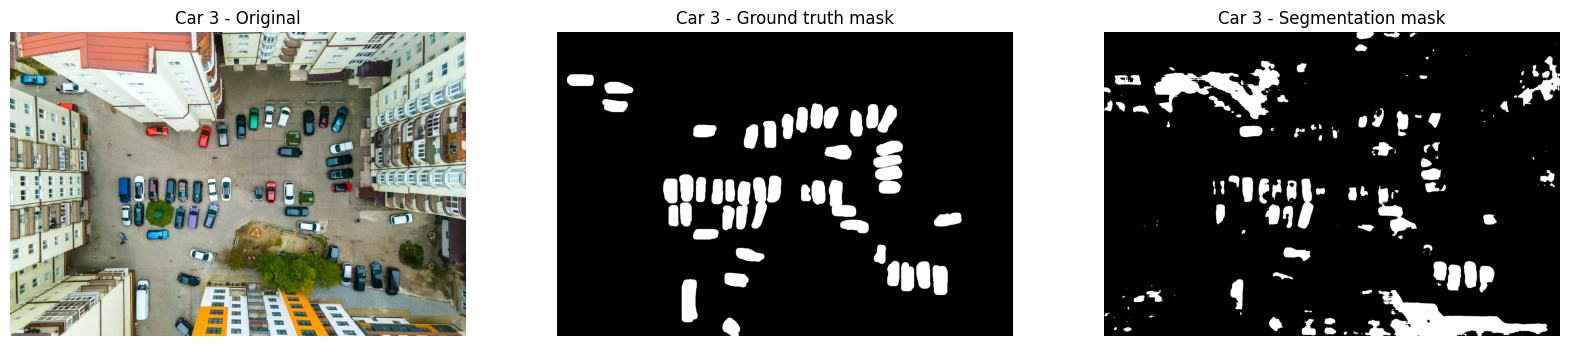

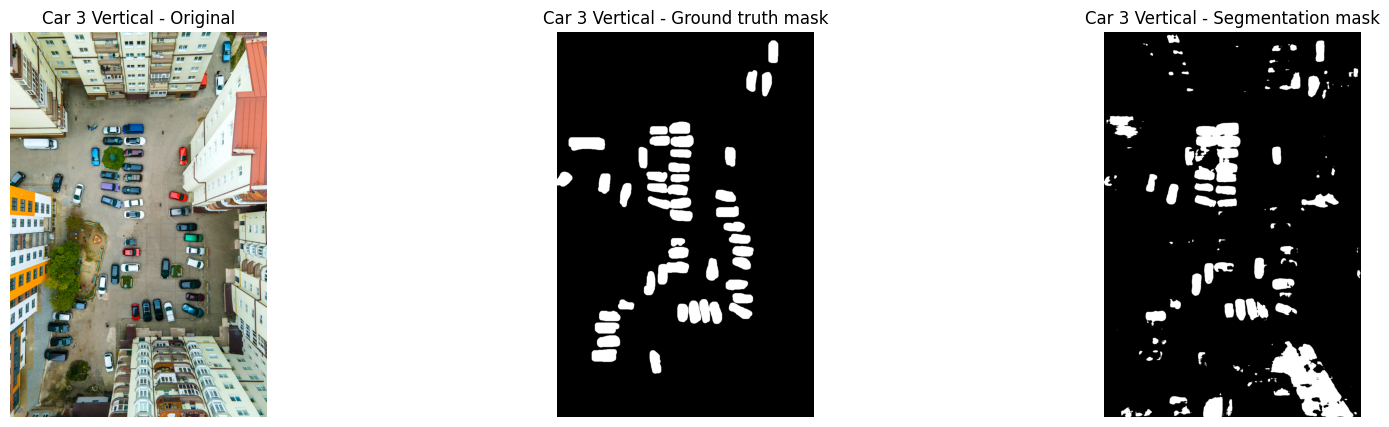

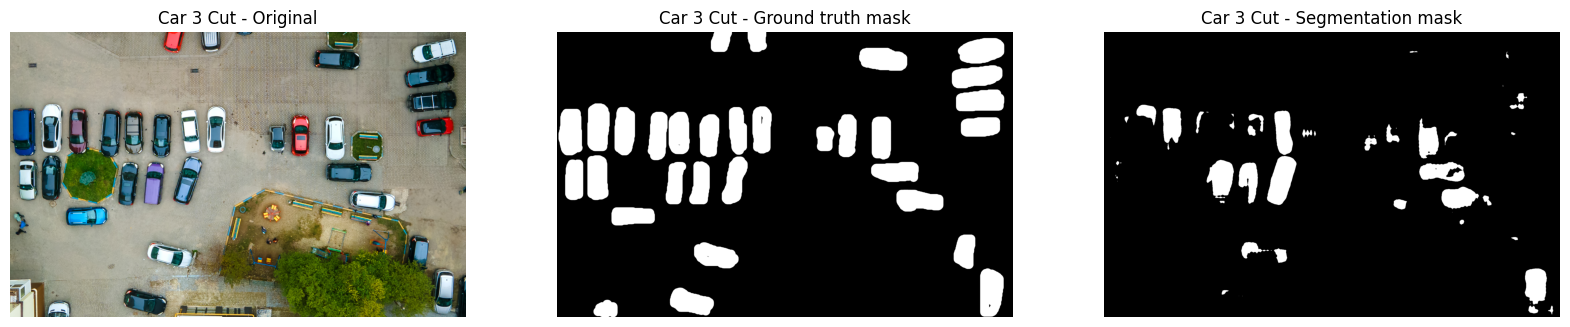

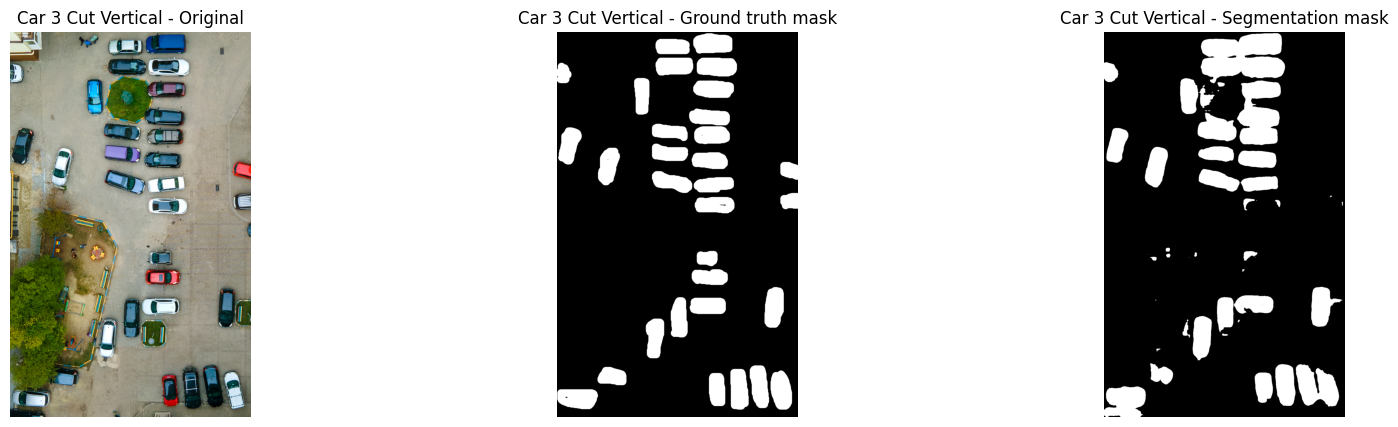

In [5]:
# Get segmentation mask image
car3_vertical, pred_mask_car_vertical_arr3 = semantic_segmentation(model, './images/car3_vertical.png', min_prob=0.95)
car3_cut, pred_mask_car_cut_arr3 = semantic_segmentation(model, './images/car3_cut.png', min_prob=0.95)
car3_cut_vertical, pred_mask_car_cut_vertical_arr3 = semantic_segmentation(model, './images/car3_cut_vertical.png', min_prob=0.95)

# Load ground truth image
_, gt_mask_car_vertical_arr3 = get_img_with_arr('./images/car3_vertical_ground_truth.png', as_binary=True)
_, gt_mask_car_cut_arr3 = get_img_with_arr('./images/car3_cut_ground_truth.png', as_binary=True)
_, gt_mask_car_cut_vertical_arr3 = get_img_with_arr('./images/car3_cut_vertical_ground_truth.png', as_binary=True)

# Ground Truth - Calculate Intersection over Union
print('Intersection over Union -> car3             : ' + str(calculate_iou(pred_mask_car_arr3, gt_mask_car_arr3)))
print('Intersection over Union -> car3 vertical    : ' + str(calculate_iou(pred_mask_car_vertical_arr3, gt_mask_car_vertical_arr3)))
print('Intersection over Union -> car3 cut         : ' + str(calculate_iou(pred_mask_car_cut_arr3, gt_mask_car_cut_arr3)))
print('Intersection over Union -> car3 cut vertical: ' + str(calculate_iou(pred_mask_car_cut_vertical_arr3, gt_mask_car_cut_vertical_arr3)))

# Display original image and masks
show_images({ 'title': 'Car 3 - Original', 'img_data': car3 }, { 'title': 'Car 3 - Ground truth mask', 'img_data': gt_mask_car_arr3 }, { 'title': 'Car 3 - Segmentation mask', 'img_data': pred_mask_car_arr3})
show_images({ 'title': 'Car 3 Vertical - Original', 'img_data': car3_vertical }, { 'title': 'Car 3 Vertical - Ground truth mask', 'img_data': gt_mask_car_vertical_arr3 }, { 'title': 'Car 3 Vertical - Segmentation mask', 'img_data': pred_mask_car_vertical_arr3})
show_images({ 'title': 'Car 3 Cut - Original', 'img_data': car3_cut }, { 'title': 'Car 3 Cut - Ground truth mask', 'img_data': gt_mask_car_cut_arr3 }, { 'title': 'Car 3 Cut - Segmentation mask', 'img_data': pred_mask_car_cut_arr3})
show_images({ 'title': 'Car 3 Cut Vertical - Original', 'img_data': car3_cut_vertical }, { 'title': 'Car 3 Cut Vertical - Ground truth mask', 'img_data': gt_mask_car_cut_vertical_arr3 }, { 'title': 'Car 3 Cut Vertical - Segmentation mask', 'img_data': pred_mask_car_cut_vertical_arr3})

### Conclusiones DeepLabV3

El modelo muestra los mejores resultados de segmentación en `car2.png`, posiblemente se deba a que la imagen contiene poco ruido. En el caso de `car1.png` y `car3.png` los resultados no son muy buenos al inicio pero la métrica de `intersection over union` mejora cuando se trata la imagen con diferente orientación y se ajusta la probabilidad mínima para detectar los pixeles etiquetados como carros. En la última prueba donde se recortó la imágen de `car3.png` se comprobó que el modelo detecta los automóviles hasta que la orientación de la imágen se procesa en vertical. Lo anterior se puede deber a que el modelo fue entrenado con imagenes de carros con una orientación muy específica.

# Segmentación semántica con LRASPP Mobilenet

## ¿Qué es lraspp_mobilenet_v3_large?

Es un modelo de **segmentación semántica eficiente** implementado en `torchvision.models.segmentation`, que combina:

    Un backbone ligero: MobileNetV3-Large

    Un decodificador rápido: LR-ASPP (Lite Reduced Atrous Spatial Pyramid Pooling)

Está diseñado para **buen rendimiento en dispositivos móviles o con recursos limitados**, manteniendo buena precisión.

## MobileNetV3-Large

Es una **red convolucional eficiente** que sirve como **extractor de características** (encoder/backbone).

#### Características clave:

    · Utiliza depthwise separable convolutions (menos operaciones).
    · Introduce squeeze-and-excitation (SE) blocks para mejorar la atención por canal.
    · Viene en dos variantes:
        · MobileNetV3-Small: más compacto.
        · MobileNetV3-Large: más potente (el que se mostrará en este ejemplo).
    · Diseñado por Google para tareas de visión en dispositivos móviles.

**Rol en el modelo**: extraer representaciones profundas y compactas de la imagen.

## LR-ASPP (Lite Reduced Atrous Spatial Pyramid Pooling)

Es una variante ligera de ASPP (usada en DeepLab), diseñada para **segmentación eficiente**.

#### ¿Qué hace?

    · Usa dilatación (atrous convolutions) para capturar información en diferentes escalas.
    · Reemplaza el costoso decodificador de DeepLabV3 con una versión más ligera y rápida.
    · Fusión de:
        · Low-level features: detalles finos
        · High-level features: contexto general

**Rol en el modelo**: produce la **máscara de segmentación final** de manera eficiente.

## COCO_WITH_VOC_LABELS_V1 (en torchvision.models.segmentation)

Este es un conjunto de **pesos preentrenados** (`weights`) que puedes usar al cargar modelos como `fcn_resnet50`, `deeplabv3_resnet101`, `lraspp_mobilenet_v3_large`, etc. en PyTorch.

#### ¿Qué significa?

    · El modelo fue entrenado en el dataset COCO (Common Objects in Context)
    · Pero usando solo las 21 clases del dataset PASCAL VOC, no las 91+ clases de COCO
    · Esto se hace para hacerlo compatible con evaluaciones o flujos de trabajo basados en VOC

#### ¿Qué contiene este conjunto de pesos?

    · Backbone preentrenado en ImageNet
    · Segmentador entrenado sobre imágenes COCO, usando solo las categorías que coinciden con VOC

#### Clases que incluye

```['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']```

## Implementación

#### Imports

In [8]:
from torchvision.io.image import decode_image
from torchvision.models.segmentation import LRASPP_MobileNet_V3_Large_Weights, lraspp_mobilenet_v3_large
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np

#### Preparación del modelo

In [9]:
# Validamos si nuestra computadora soporta CUDA o solo CPU y lo guardamos en una variable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Usamos los pesos del modelo pre entrenado e iniciamos el modelo indicando el DEVICE que usará.
weights = LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1;
model = lraspp_mobilenet_v3_large(weights=weights).to(DEVICE)

# Activamos el modo de evaluación del modelo, esto implica cambiar el comportamiento interno de las capas.
_ = model.eval()

#### Funciones útiles

In [12]:
# open_tensor_image: función que nos ayuda a abrir una imagen y devuelve un torch.Tensor con la forma [C, H, W] (canal, alto, ancho)
# inputs:
#    path: ruta de la imagen
def open_tensor_image(path, as_binary=False):
    # Abrimos la imagen como tensor usando decode_image
    img = decode_image(path)

    if as_binary:
        return to_pil_image(img).convert('1')
    
    # si la imagen tiene 4 canales, sobreescribimos para solo dejar 3.
    if img.shape[0] == 4:
        img = img[:3, :, :]

    return img

# process_tensor_image: función que nos ayuda a pre procesar una imagen torch.Tensor. Devuelve la imagen normalizada.
# inputs:
#    img: imagen del tipo torch.Tensor
def process_tensor_image(img):
    # Creamos un pipeline de transformaciones para usar con la imagen.
    transform = transforms.Compose([
        # Convertimos los valores a float para su posterior normalización
        transforms.ConvertImageDtype(torch.float),
        # Operación para normalizar la imagen.
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Transformamos la imagen y el resultado lo asignamos a una nueva variable.
    img_tensor = transform(img)

    # Agregamos una nueva dimensión en la posición 0 ya que es el formato que espera cualquier modelo de pytorch. Despues movemos el tensor al dispositivo donde será procesado, "cuda" o "cpu".
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    return img_tensor

# image_segmentation: Función que nos ayuda a ejecutar el modelo sobre una imagen dada. Devuelve la mascara binarizada y la mascara predicha por el modelo.
# inputs:
#     img: imagen del tipo torch.Tensor
def image_segmentation(img):
    # Obtenemos las clases desde los pesos y convertimos la lista en un diccionario.
    class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

    # Obtenemos el indice de la clase __background__
    category = class_to_idx["__background__"]

    # Le indicamos a PyTorch que no almacene los gradientes, para mejorar el desempeño de la predicción.
    with torch.no_grad():
        # Usamos el modelo para hacer la predicción y obtenemos el resultado.
        prediction = model(img)["out"]

        # Usamos softmax a lo largo del eje dim=1.
        prediction_image = prediction.softmax(dim=1)

        # Obtenemos la mascara predicha por el modelo usando la categoria obtenida anteriormente.
        predicted_mask = prediction_image[0, category].cpu()

    # Creamos una mascara binaria con todo aquello que tenga menos del 95% de probabilidad de ser el background de la imagen.
    binary_mask = (predicted_mask < 0.95).float()

    # Retornamos la mascara binarizada y la mascara predicha.
    return binary_mask, predicted_mask.detach().cpu().numpy()

# show_images: Función que nos permite mostrar la imagen original, la mascara binarizada, la mascara predicha y el ground truth
# inputs:
#    img: Imagen original.
#    binary_mask: Imagen de mascara binarizada.
#    predicted_mask: Imagen de mascara predicha
#    ground_truth: Imagen de ground truth
def show_images(img, binary_mask, predicted_mask, ground_truth):
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title("Imagen original")
    plt.subplot(1,4,2)
    plt.title(f"Ground Truth")
    plt.imshow(ground_truth, cmap='gray')
    plt.subplot(1,4,3)
    plt.title(f"Máscara binarizada")
    plt.imshow(binary_mask, cmap='gray')
    plt.subplot(1,4,4)
    plt.title(f"Mascara predicha")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# calculate_iou: Función que nos permite calcular que tanto se sobrepone la mascara binarizada sobre el ground truth.
# inputs:
#    pred: mascara predicha
#    gt: mascara Ground truth
def calculate_iou(pred, gt):
    pred_np = pred.cpu().numpy() if torch.is_tensor(pred) else pred
    gt_np = gt.cpu().numpy() if torch.is_tensor(gt) else gt
    intersection = np.logical_and(pred_np, gt_np).sum()
    union = np.logical_or(pred_np, gt_np).sum()
    return intersection / union if union != 0 else 0.0

#### Aplicamos el modelo a la imagen car1.png

Porcentaje de predicción:  0.41288091694358137


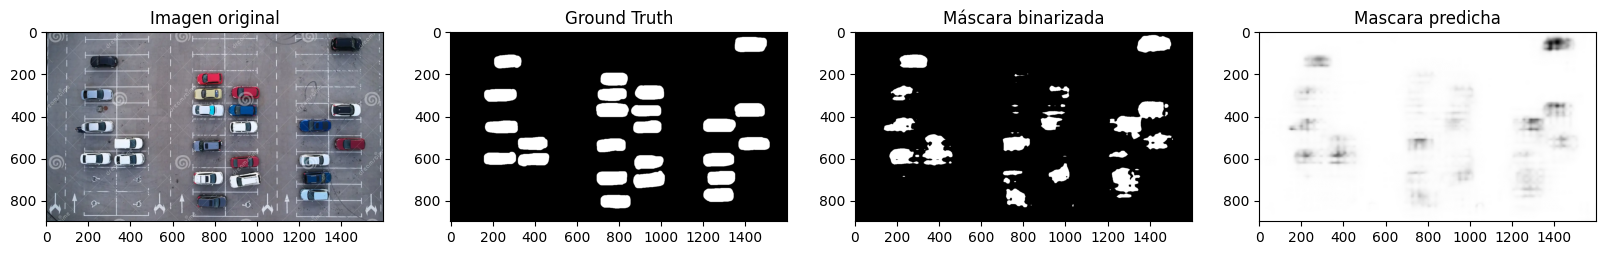

In [13]:
car1 = open_tensor_image('./images/car1.png')
car1_ground_truth = open_tensor_image('./images/car1_ground_truth.png', True)
car1_preproc = process_tensor_image(car1)
binary_mask, predicted_mask = image_segmentation(car1_preproc)
print('Porcentaje de predicción: ', calculate_iou(binary_mask, car1_ground_truth))
show_images(car1, binary_mask, predicted_mask, car1_ground_truth)

#### Aplicamos el modelo a la imagen car2.png

Porcentaje de predicción:  0.4290434596380658


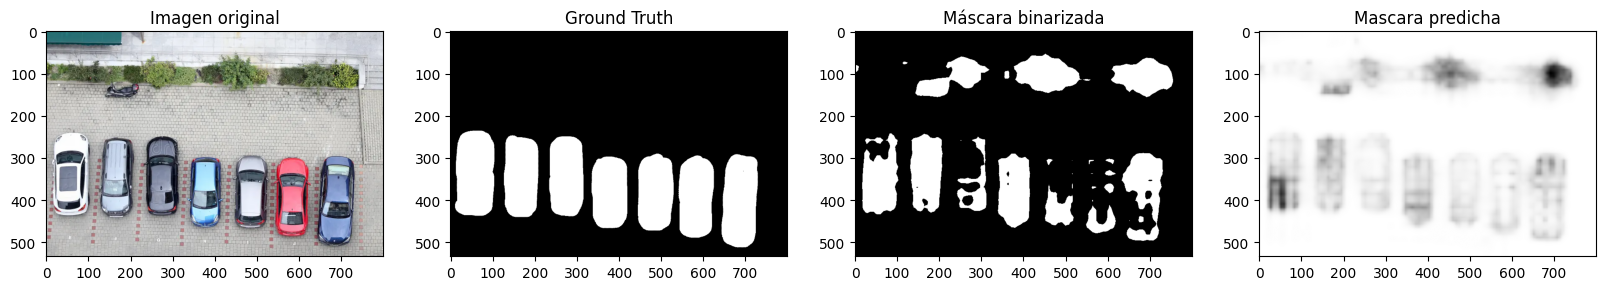

In [14]:
car2 = open_tensor_image('./images/car2.png')
car2_ground_truth = open_tensor_image('./images/car2_ground_truth.png', True)
car2_preproc = process_tensor_image(car2)
binary_mask, predicted_mask = image_segmentation(car2_preproc)
print('Porcentaje de predicción: ', calculate_iou(binary_mask, car2_ground_truth))
show_images(car2, binary_mask, predicted_mask, car2_ground_truth)

#### Aplicamos el modelo a la imagen car3.jpg

Porcentaje de predicción:  0.3613564358289406


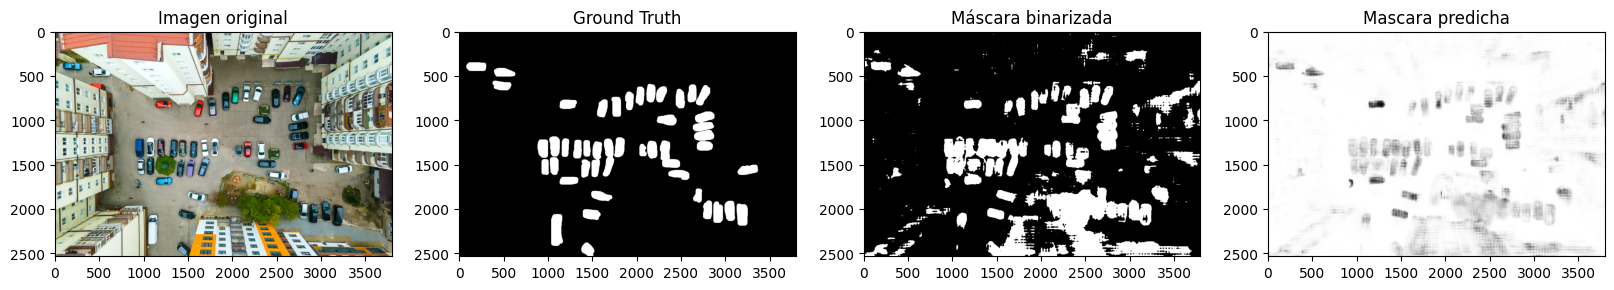

In [15]:
car3 = open_tensor_image('./images/car3.jpg')
car3_ground_truth = open_tensor_image('./images/car3_ground_truth.png', True)
car3_preproc = process_tensor_image(car3)
binary_mask, predicted_mask = image_segmentation(car3_preproc)
print('Porcentaje de predicción: ', calculate_iou(binary_mask, car3_ground_truth))
show_images(car3, binary_mask, predicted_mask, car3_ground_truth)

In [16]:
# Nos permite liberar la memoria utilizada en la GPU y limpiar el caché.
torch.cuda.empty_cache()

## Conclusión

En este experimento se empleó el modelo **`lraspp_mobilenet_v3_large`** utilizando el conjunto de pesos **`COCO_WITH_VOC_LABELS_V1`**. Durante las pruebas, se observó que la clase **`__background__`** proporcionó mejores resultados visuales en comparación con la clase **`car`**, la cual no logró detectar adecuadamente los vehículos cuando las imágenes se tomaron desde una perspectiva satelital.

Adicionalmente, se exploraron múltiples modelos alternativos, tales como **FCN** con pesos entrenados en COCO, así como variantes de **U-Net**, **U-Net++**, **PSPNet** y **UPerNet**, todos ellos con distintos *encoders* (incluyendo `ImageNet`). Sin embargo, ninguno logró segmentar correctamente los automóviles desde esta vista aérea, lo que sugiere que los modelos preentrenados disponibles actualmente no están optimizados para este tipo de imágenes satelitales, y probablemente requerirían un ajuste fino (*fine-tuning*) o entrenamiento especializado sobre un conjunto de datos más específico.


# Segmentación con YOLOv8

Segmentación con el modelo pre-entrenado YOLO v8 para intentar segmentar automoviles vistos de una foto elevada.

El modelo YOLOv8 está entrenado para detección de objetos urbanos: autos, personas, letreros, semáforos, etc.

A diferencia de LRASPP y DeepLabV3, YOLOv8 aplica `segmentación de instancia`.

## Implementación

> NOTA: El siguiente código debe ejecutarse en Google Colab. Se debe copiar la carpeta `images` a Google Drive previo a ejecutar la implementación en YOLOv8 y renombrar la carpeta a `imagenesColab`.

Primero instalamos la librería de "ultralytics", que es la que contiene el modelo pre-entrenado YOLOv8

In [ ]:
!pip install -q ultralytics

Luego importamos las librerías de OpenCV, Matplolib, PIL, Numpy y el montaje de Google Drive

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos el modelo YOLOv8 para segmentación

In [ ]:
model = YOLO("yolov8s-seg.pt")

Cargamos las imágenes con las que vamos a trabajar desde Google Drive, y las convertimos de BGR a RGB

In [ ]:
image_paths = [
    "/content/drive/MyDrive/imagenesColab/Cars/car1.png",
    "/content/drive/MyDrive/imagenesColab/Cars/car2.png",
    "/content/drive/MyDrive/imagenesColab/Cars/car3.png"
]
images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in image_paths]

Ejecutamos la inferencia con el modelo YOLOv8, Superponemos las máscaras en color verde sobre las imagenes y hacemos un arreglo de imagenes solo para mostralas horizontalmente


image 1/1 /content/drive/MyDrive/imagenesColab/Cars/car1.png: 416x640 2 cars, 572.7ms
Speed: 2.0ms preprocess, 572.7ms inference, 7.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/drive/MyDrive/imagenesColab/Cars/car2.png: 448x640 1 car, 7 cell phones, 876.6ms
Speed: 2.5ms preprocess, 876.6ms inference, 22.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/MyDrive/imagenesColab/Cars/car3.png: 448x640 1 bottle, 14 cell phones, 691.2ms
Speed: 3.0ms preprocess, 691.2ms inference, 41.4ms postprocess per image at shape (1, 3, 448, 640)


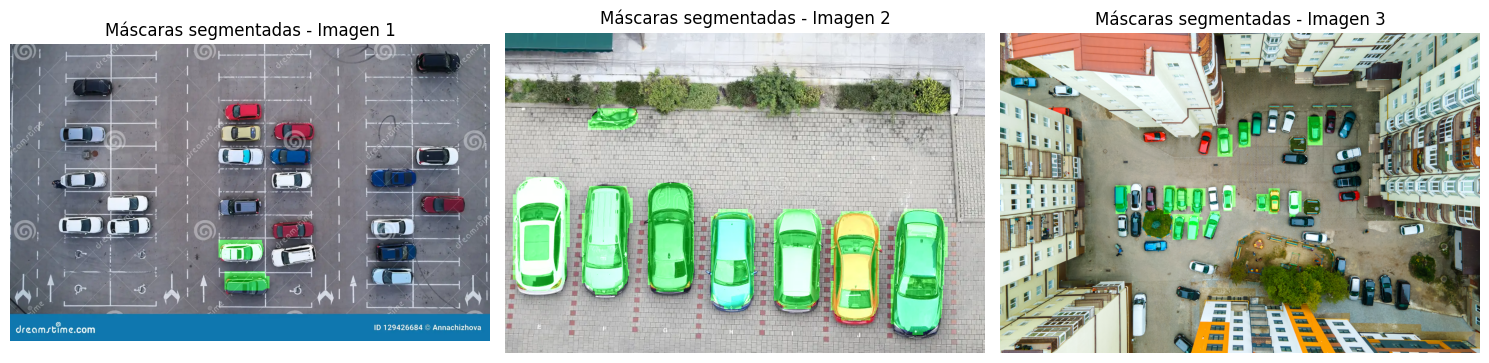

In [ ]:
results_list = [model(p)[0] for p in image_paths]
annotated_images = []

for img, res in zip(images, results_list):
    annotated = img.copy()
    height, width = annotated.shape[:2]

    if res.masks is not None: #Verificamos que el resultado "res" contenga máscaras segmentadas
        for mask in res.masks.data: #iteración sobre cada máscara
            mask_np = mask.cpu().numpy()
            resized_mask = cv2.resize(mask_np, (width, height), interpolation=cv2.INTER_NEAREST) #mantenemos la interpolacion binaria
            color_mask = np.zeros_like(annotated)
            color_mask[resized_mask > 0.3] = [0, 255, 0] #pintanos de verde los píxeles de la mascara binaria
            annotated = cv2.addWeighted(annotated, 1.0, color_mask, 0.5, 0) #se superpone la mascara sobre la imagen

    annotated_images.append(annotated)


plt.figure(figsize=(15, 5))
for i, img in enumerate(annotated_images):
    plt.subplot(1, len(annotated_images), i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Máscaras segmentadas - Imagen {i+1}")
plt.tight_layout()
plt.show()


Guardamos la imágenes con las mascaras previamente calculadas (o imágenes predichas) en Google Drive para compararlas después en el ground truth y mostramos si las guardó exitosamente

In [ ]:
output_dir = "/content/drive/MyDrive/imagenesColab/Cars/ground_truth"
os.makedirs(output_dir, exist_ok=True) #crea el directorio en Google Drive si es que no existe

for idx, (res, path) in enumerate(zip(results_list, image_paths)): #itera sobre los resultados de la segmentación generados por el modelo y por las rutas de las imagenes
    filename = os.path.splitext(os.path.basename(path))[0] #obtenemos el nombre del archivo sin extensión

    if res.masks is not None: #verificamos si hay realmente máscaras
        mask_combined = np.zeros(res.masks.data[0].shape, dtype=np.uint8) #se inicia una mascara vacía para combinarlas todas
        for mask in res.masks.data:
            mask_np = (mask.cpu().numpy() > 0.5).astype("uint8") #se aplica umbral de 0.5 para binarizar la máscara
            mask_combined = np.logical_or(mask_combined, mask_np) #se va acumulando las máscaras en una sola

        mask_combined = (mask_combined * 255).astype("uint8") #se convuerte la mascara binaria a escala de grises
        output_path = os.path.join(output_dir, f"{filename}_pred.png") #conbtruye la ruta final del archivo
        cv2.imwrite(output_path, mask_combined) #usamos OpenCV para guardar la imagen en formato png
        print(f"Guardada: {output_path}") #imprimimos si fue gyardado con exito el archivo


Guardada: /content/drive/MyDrive/imagenesColab/Cars/ground_truth/car1_pred.png
Guardada: /content/drive/MyDrive/imagenesColab/Cars/ground_truth/car2_pred.png
Guardada: /content/drive/MyDrive/imagenesColab/Cars/ground_truth/car3_pred.png


Mostramos las máscaras ground truth en horizontal, solo para referencia

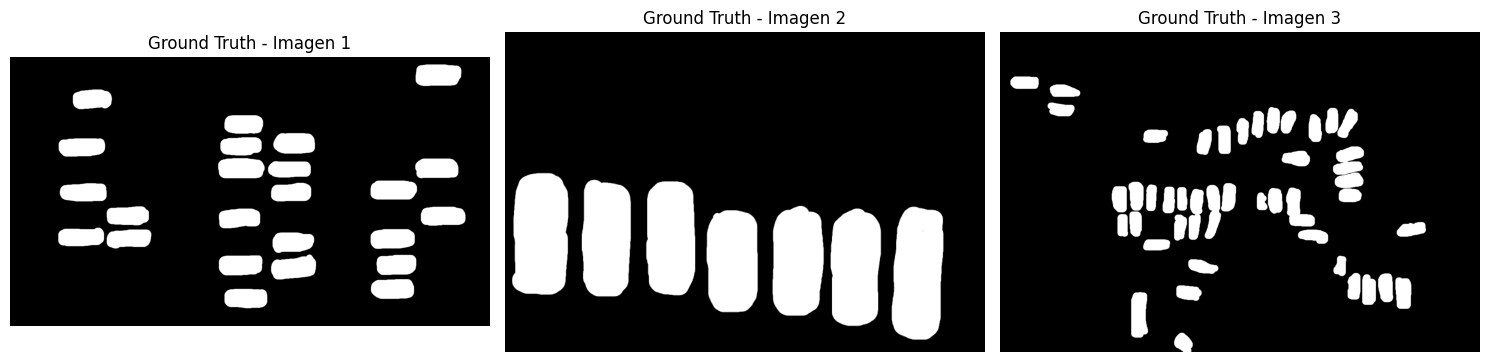

In [ ]:
ground_truth_dir = "/content/drive/MyDrive/imagenesColab/Cars/ground_truth" #definimos la ruta de las mascaras ground truth en Google Drive

gt_paths = sorted(glob(os.path.join(ground_truth_dir, "*[!_pred].png"))) #buscamos las imagenes que no contienen _pred como sufijo

plt.figure(figsize=(5 * len(gt_paths), 5))
for i, gt_path in enumerate(gt_paths):
    mask = Image.open(gt_path).convert("L")
    plt.subplot(1, len(gt_paths), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Ground Truth - Imagen {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Calculamos el IoU (Intersection over Union) entre el ground truth y las predicciones.
Los valores típicos son:
IoU = 1.0 Superposición perfecta
IoU = 0.0 Ninguna superposición
IoU > 0.5 Aceptable
IoU < 0.3 Mala predicción

In [ ]:
from glob import glob #permite buscar archivos que coincidan con un patrón

def calculate_iou(mask_pred, mask_gt): #compara las dos máscaras binarias
    intersection = np.logical_and(mask_pred, mask_gt).sum() #cantidad de píxeles donde ambas máscaras tienen valor positivo
    union = np.logical_or(mask_pred, mask_gt).sum() #cantidad de píxeles donde al menos una máscara es positiva
    return intersection / union if union > 0 else float('nan')

ground_truth_dir = "/content/drive/MyDrive/imagenesColab/Cars/ground_truth" #ruta de archivos de imagenes a comparar
ious = []

for gt_path in sorted(glob(os.path.join(ground_truth_dir, "*[!_pred].png"))): #iteración sobre las imagenes ground truth
    filename = os.path.basename(gt_path)
    name_base = filename.replace(".png", "")
    pred_path = os.path.join(ground_truth_dir, f"{name_base}_pred.png") #busca el archivo de máscara predicha correspondiente

    if os.path.exists(pred_path): #procede si encontró una máscara predicha
        mask_gt = np.array(Image.open(gt_path).convert("L")) #se cargan las imagenes en escala de grises
        mask_pred = np.array(Image.open(pred_path).convert("L"))
        mask_pred = cv2.resize(mask_pred, (mask_gt.shape[1], mask_gt.shape[0]), interpolation=cv2.INTER_NEAREST) #nos aseguramos que las imagenes tengan el mismo tamaño

        mask_gt_bin = mask_gt > 127 #convierte las máscaras de escala de grises a binarias usando umbral 127
        mask_pred_bin = mask_pred > 127

        iou = calculate_iou(mask_pred_bin, mask_gt_bin) #calcula la métrica del IoU
        ious.append(iou)
        print(f"IoU para {filename}: {iou:.3f}") #lmuestra el resuluado
    else:
        print(f"No se encontró predicción para {filename}") #se notifica si no existe

if ious:
    print(f"\nIoU promedio: {np.nanmean(ious):.3f}") #se muestra el promedio final
else:
    print("No se encontraron comparaciones válidas.") #mensaje si no se encontró ninguna


IoU para car1.png: 0.024
IoU para car2.png: 0.866
IoU para car3.png: 0.229

IoU promedio: 0.373


## Conclusiones YOLOv8

Se evaluó la segmentación de automóviles utilizando el modelo YOLOv8 con IoU como métrica de desempeño. Se obtuvo un IoU promedio de 0.373, lo cual indica una segmentación baja, con baja coincidencia general entre las máscaras predichas y las ground truth. La de mejor coincidencia fue la imagen Car2 que tiene los automoviles más grandes relativamente, lo que me hace pensar que podríamos obtener mejores resultados con objetos más cercanos.

# Conclusiones generales

En los 3 modelos que se probaron, los mejores resultados son para la imágen de `car2`, esto debido a que la imágen tiene menos elementos de ruido. Caso contrario a la imágen de `car1` que se procesó con ruido y muestra los peores resultados en todos los modelos. En el caso de `car3` los resultados son variables en cada modelo pero existe una tendencia a no identificar muy bien los automóviles, esto puede ser debido al formato de la imágen que tiene una dimensión muy grande y contiene demasiados objetos distintos a los carros como edificios y árboles.

Al consultar algunos de los datasets se encontró que varias imagenes de carros con las cuales se entrenaron los modelos no contiene imagenes tan parecidas a las que se usaron en esta actividad (autos vistos desde arriba), lo cual sugiere el uso de un ajuste fino (fine-tuning). Aún asi en el caso de DeepLabV3 se logró obtener buenos resultados haciendo un ajuste a la probabilidad para etiquetar pixeles que pertenecen a la clase autos y usando las imagenes con distinta orientación y tamaño, esto es un claro indicativo que el pre-procesamiento de imagenes puede ayudar a obtener mejores resultados.